- ver0.0 2025/10/27 シェブロンパターン測定まで準備 (小川)
- ver0.1 2025/10/28 全体を微修正, qubitの基本測定とラビ振動の規格化を追加 (小川)
- ver0.2 2025/10/29 読み出し分類器まで追加 (小川)

<span style="color: red; ">**examples/1Q-calibrationのフォルダをご自身のworkspaceに移動させてから, 実験を行ってください.**</span>

## クラウド設定

一度だけ実行すれば良い.

In [ ]:
# from pathlib import Path

# config = """[default]
# url=https://api.qiqb-cloud.jp
# api_token=xxxxxxx
# """
# Path("~/.oqtopus").expanduser().write_text(config)
# print("Configuration saved.")

Configuration saved.


QIQBクラウドのリンク：https://www.qiqb-cloud.jp/  
  
「ジョブ」のタブで, 実行済み・実行中のジョブを確認することができます. 

## 1qubitの較正 

In [1]:
from quri_parts_oqtopus.backend import OqtopusSseBackend
from oqtopus_sse_pulse.adapter import QuriAdapter, collect_payloads_from_job, collect_session_from_job
from oqtopus_sse_pulse.plotters import plot_payload

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

DEVICE = "anemone" # デバイス名 (勉強会ではanemoneに固定)
backend = OqtopusSseBackend() # OqtopusSseBackendのインスタンスを作成

In [2]:
def experiment(program: str) -> list:
    """
    指定した実験プログラムを実行し, 測定結果のペイロードを返す関数.
    """

    # ジョブの実行
    job = backend.run_sse(
        file_path=f"{program}.py",
        device_id=f"{DEVICE}-pulse",
        name=program,
    )
    print(f"job_id = {job.job_id}")

    # ジョブの完了待ち
    job.wait_for_completion()
    print(f"job_status = {job.status}  elapsed={job.execution_time}")

    # QuriAdapterの作成
    adapter = QuriAdapter(backend)

    # 測定結果の取得
    payloads = collect_payloads_from_job(
        backend=adapter,
        job_id=job.job_id,
    )
    
    return payloads

### シェブロンパターン測定

まずは試しに, `1Q-calib-1_chevron_pattern.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してみてください. 

job_id = 06900c40-74e3-73f4-8000-f0c51efc39da
job_status = succeeded  elapsed=44.093


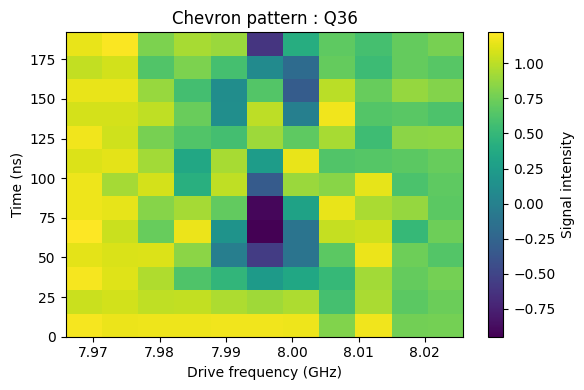

In [7]:
payloads = experiment("1Q-calib-1_chevron_pattern")

# グラフ描画
p = payloads[0]
fig, ax = plot_payload(p, program="1Q-calib-1_chevron_pattern")

<span style="color: red; ">**[自主作業1] 得られたシェブロンパターンから, このqubitの共鳴周波数を求めてください.**</span> 
- 各駆動周波数におけるラビ振動をフーリエ変換して各ラビ周波数を計算し, それらのデータ点にフィッティングを行うことにより, ラビ振動が最小となる駆動周波数を算出することができます. 
- フィッティング関数は以下を使用してください:
$$ f_{\rm rabi} = \sqrt{(f_{\rm q} - f_{\rm d})^2 + f_{\rm rabi,min}^2} $$
- ここで$f_{\rm rabi}$は各駆動周波数におけるラビ振動周波数, $f_{\rm q}$はqubitの共鳴周波数, $f_{\rm d}$はマイクロ波駆動周波数, $f_{\rm rabi,min}$は共鳴駆動条件で現れる最小ラビ振動周波数です. $f_{\rm d}$は掃引パラメータ, $f_{\rm q}$, $f_{\rm rabi,min}$はフィッティングによって決定されるパラメータです.  

[補足]
- マイクロ波駆動振幅を大きくすると, それに比例してラビ振動周波数が大きくなりますが, それだけでなく, 上記フィッティングで得られるqubit共鳴周波数にも微小なシフトが観測されるはずです. これはac-シュタルク効果と呼ばれる現象で, 一般にマイクロ波駆動中のqubitは駆動の影響を受けてその共鳴周波数が微小にシフトします. ゲート忠実度を突き詰める場合には, DRAGなどのテクニックによってこのシフトの影響を考慮したパルス設計を行う必要があります. 
- シェブロンパターンを細かく測定すると, qubitの共鳴とは別に細い共鳴信号が見えることがあります. これは多くの場合, トランズモン中または近くの不純物によって生じる不要2準位系(two-level system: TLS)の共鳴が見えているものだと考えられています. TLSの共鳴周波数がqubitの共鳴周波数に近かったり, qubitとの結合が大きかったりすると, qubitのコヒーレンス性能の悪化をもたらします. さらにTLSは数時間〜数日の時間スケールで特性が変化することがあり, これがqubitの時間安定性にも影響を与えることがあります. 

### qubitの基本測定

上のシェブロンパターン測定では, お試し測定という意味で, ラビ振動測定のパルスシーケンスや読み出しリターン信号が適切に処理されるように準備されたメソッドを用いました.  
これ以降ではパルスレベル実験の基礎を学ぶために, 基本的な測定実験から始めていきます.    

`1Q-calib-2_measure.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してみてください. 

In [83]:
payloads = experiment("1Q-calib-2_measure")

job_id = 069020d8-9cae-7488-8000-9db2655cdb0a
job_status = succeeded  elapsed=8.823


この実験では, 最も基本的なqubit測定メソッドである`measure`メソッドを用いて, `waveform = [0.1 + 0.1j, 0.1 + 0.1j, 0.1 + 0.1j, 0.1 + 0.1j, 0.1 + 0.1j]`によって定義された波形をqubitに照射して, 読み出し波形の取得を行っています.   
返ってきた`payloads`のうち, `"raw_data_real"`および`"raw_data_imag"`には読み出しパルス波形 (`mode="avg"`と選択時には`shots=1024`回分の積算波形) の実部および虚部のリスト, `"time_range"`には対応する時間リスト, `"kerneled_data_real"`および`"kerneled_data_imag"`には読み出しパルス波形を時間平均した値が格納されています.  
通常はkerneled dataの複素数1つを見て, この実験状況における測定結果を読み取ります. 
以下ではそれらをグラフに描画してみます. 

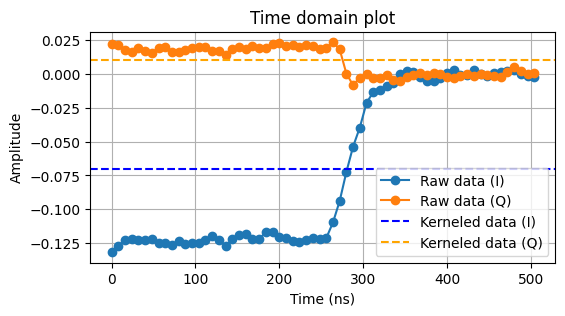

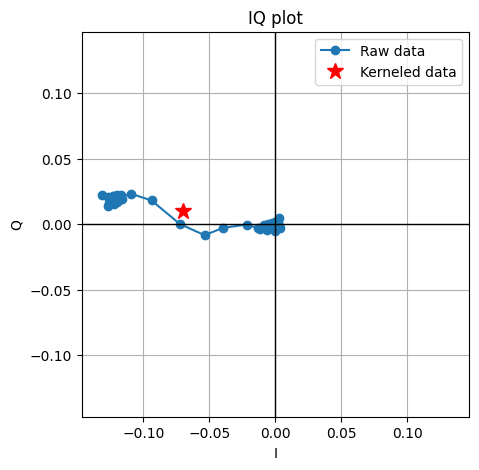

In [84]:
# 測定で得られた全データ
raw_data_real = payloads[0]["raw_data_real"]
raw_data_imag = payloads[0]["raw_data_imag"]
kerneled_data_real = payloads[0]["kerneled_data_real"]
kerneled_data_imag = payloads[0]["kerneled_data_imag"]
t_list = payloads[0]["time_range"]

# 時間プロットを表示
plt.figure(figsize=(6, 3))
plt.plot(t_list, raw_data_real, 'o-', label='Raw data (I)')
plt.plot(t_list, raw_data_imag, 'o-', label='Raw data (Q)')
# kerneled_dataの横線を引く
plt.axhline(kerneled_data_real, linestyle='--', color='b', label='Kerneled data (I)')
plt.axhline(kerneled_data_imag, linestyle='--', color='orange', label='Kerneled data (Q)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Time domain plot')
plt.legend()
plt.grid(True)
plt.show()

# IQプロットを表示
plt.figure(figsize=(5,5))
plt.plot(raw_data_real, raw_data_imag, 'o-', label='Raw data')
plt.plot(kerneled_data_real, kerneled_data_imag, '*', label='Kerneled data', markersize=12, color='red')
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axvline(0, linewidth=1, color='k')
max = np.max(np.sqrt(np.array(raw_data_real)**2 + np.array(raw_data_imag)**2)) * 1.1 # 原点を中心にする
plt.xlim(-max, max)
plt.ylim(-max, max)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ plot')
plt.legend()
plt.grid(True)
plt.show()


[補足]
- ここではパルス波形をリストの形であらわに書き下して定義しましたが, `np.exp()`や`np.cos()`といった関数を用いて解析的に表せる形のnumpy.ndarrayでもOKです. 
- `qubex.pulse`にはさまざまな実用的なパルス波形が定義されています. `from qubex.pulse import ...`でインポートしてご使用いただいてもOKです. 

### ラビ振動の規格化

ここでは, 改めてラビ振動を観測する実験を行い, 読み出しリターン信号のIQ平面上での振る舞いを観察します.  
`1Q-calib-3_rabi.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください. 

In [38]:
payloads = experiment("1Q-calib-3_rabi")

job_id = 06902349-f640-7235-8000-424c32fbac5d
job_status = succeeded  elapsed=20.045


この実験では`sweep_parameter`メソッドを用いて, 矩形波`[ampl] * int(T/2)`の長さ`T`を掃引しながら, ラビ振動の測定を行っています.   
返ってきた`payloads`の`"data_real"`および`"data_imag"`には, 各パルス長さ`T`の時のqubit読み出し結果のkerneled dataの実部および虚部,  `"time_range"`には対応するパルス時間リストが格納されています.  
以下ではそれらをグラフに描画してみます. 

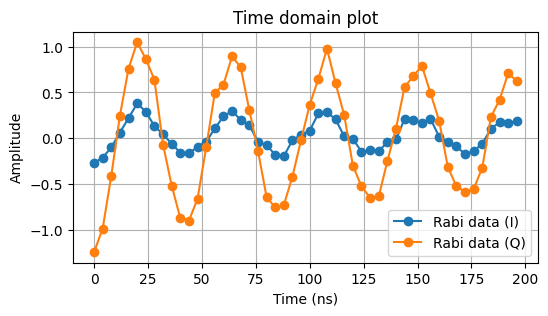

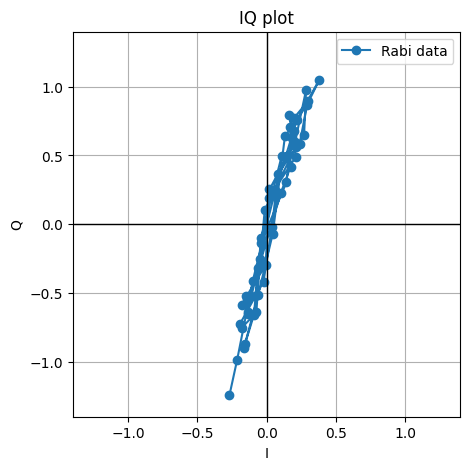

In [39]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
t_list = payloads[0]["time_range"]

# 時間プロットを表示
plt.figure(figsize=(6, 3))
plt.plot(t_list, data_real, 'o-', label='Rabi data (I)')
plt.plot(t_list, data_imag, 'o-', label='Rabi data (Q)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Time domain plot')
plt.legend()
plt.grid(True)
plt.show()

# IQプロットを表示
plt.figure(figsize=(5,5))
plt.plot(data_real, data_imag, 'o-', label='Rabi data')
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axvline(0, linewidth=1, color='k')
max = np.max(np.sqrt(np.array(data_real)**2 + np.array(data_imag)**2)) * 1.1 # 原点を中心にする
plt.xlim(-max, max)
plt.ylim(-max, max)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ plot')
plt.legend()
plt.grid(True)
plt.show()


<span style="color: red; ">**[自主作業2] このIQ平面上の振動を, Z期待値 $\langle Z \rangle \in[-1,1]$に対応させる関数`z_expectation_value()`を作成してください.**</span> 
- IQ平面上において, ラビ振動の開始点は$|\rm g\rangle$状態, その反対側の点は$|\rm e\rangle$状態に対応します. それらの点は, Z期待値 $\langle Z \rangle \in[-1,1]$の$+1$, $-1$にそれぞれ対応します. 
- したがって上記のラビ振動測定結果の`data_real = payloads[0]["data_real"]`, `data_imag = payloads[0]["data_imag"]`を用いることで, (実部, 虚部)→Z期待値 と変換させる関数`z_expectation_value(real, imag)`が定義できるはずです. 
- 振動軸の傾きや切片の取得は, 主成分分析(PCA)を用いると便利です. `from sklearn.decomposition import PCA`でインポートできます. 
- 振動軸方向の振動に対して, 減衰振動曲線でフィッティングを行い, ラビ振動の振幅と定数オフセットを取得します. これらを用いると(実部, 虚部)→Z期待値 の変換が計算できるはずです. 
- 減衰振動曲線でフィッティングにおけるラビ振動数の初期値は, ラビ振動をフーリエ変換してピークとなる周波数成分を取得しておくとこれが利用できます. 

In [9]:
def z_expectation_value(real: float, imag: float) -> float:
    """
    IQ平面上の点(real, imag)をZ期待値 <Z> ∈ [-1, 1] に変換する関数.
    """
    # ここにコードを記述してください.
    pass

### π/2パルス較正

ここでは, パルス長固定の波形に対して振幅を掃引し, π/2パルス (hpiパルス) を実現する振幅を決定する較正を行います.  
`1Q-calib-4_hpi_pulse.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください. 

In [87]:
payloads = experiment("1Q-calib-4_hpi_calib")

job_id = 069020dd-d87f-78c5-8000-bd6ea8c84334
job_status = succeeded  elapsed=13.769


この実験では, 振幅値 (0~1の範囲の無次元相対値)を掃引しながら, Flattopパルス (qubex.pulseで定義されているパルスクラスのオブジェクト. 立ち上がり・立ち下がりはcosine形状で長さはtau=12ns, 全体の長さはduration=32nsなので, flattop部の長さは8ns)を4回照射し, qubitのZ測定を行っています.  
振幅の掃引に対して, Z期待値は正弦振動を示すはずです.  
特に, 最初に$\langle Z \rangle = +1$となる振幅条件では, ちょうどFlattopパルス1回が90°回転に対応し, これが適切なhpiパルス条件となります. 

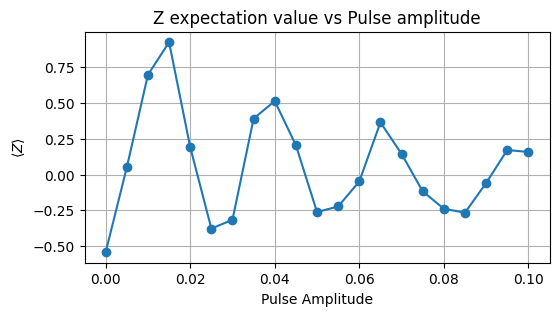

In [ ]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
ampl_list = payloads[0]["ampl_range"]

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_list = [z_expectation_value(r, i) for r, i in zip(data_real, data_imag)]

# グラフ描画
plt.figure(figsize=(6, 3))
plt.plot(ampl_list, z_exp_list, 'o-')
plt.xlabel('Pulse Amplitude')
plt.ylabel(r'$\langle Z \rangle$')
plt.title('Z expectation value vs Pulse amplitude')
plt.grid(True)
plt.show()

<span style="color: red; ">**[自主作業3] 測定結果を正弦関数でフィッティングすることで, 適切なhpiパルス振幅`hpi_amplitude`を求めてください.**</span> 

In [ ]:
def obtain_hpi_amplitude(z_exp_list: list, ampl_list: list) -> float:
    """
    Z期待値リストと対応する振幅リストから, π/2パルスに対応する振幅を取得する関数.
    """
    # ここにコードを記述してください.
    pass

正しくhpiパルスが較正できていることを確認します.  
`1Q-calib-5_hpi_repeat.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [31]:
payloads = experiment("1Q-calib-5_hpi_repeat")

job_id = 0690223b-967c-7c6a-8000-d38e6aac8e32
job_status = succeeded  elapsed=13.555


正しくhpiパルスが較正できていれば, 測定結果をグラフに描くと, Z期待値は$+1$と$-1$の間を反復横跳びするように動くはずです. 

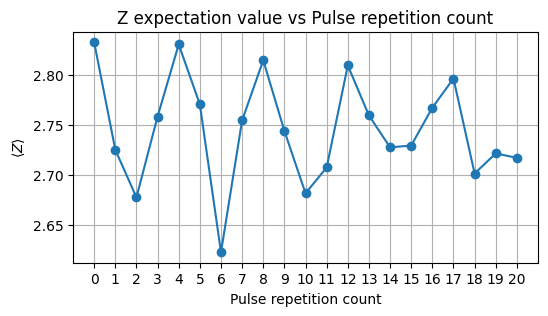

In [ ]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
n_repeat_list = payloads[0]["n_repeat_list"]

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_list = [z_expectation_value(r, i) for r, i in zip(data_real, data_imag)]

# グラフ描画
plt.figure(figsize=(6, 3))
plt.plot(n_repeat_list, z_exp_list, 'o-')
plt.xlabel('Pulse repetition count')
plt.ylabel(r'$\langle Z \rangle$')
plt.title('Z expectation value vs Pulse repetition count')
plt.xticks(n_repeat_list)
plt.grid(True)
plt.show()

### 回転軸を変えられることの確認

上で較正したhpiパルスの回転軸を$X$軸であると定義します.  
このhpiパルスの搬送波の位相をずらすことで, $Y$軸や$-X$軸や任意の角度の軸周りの回転も実現できることを確認します.  
以下の実験では, 最初に$X$軸周りのhpiパルスを照射して状態を$-Y$軸先端に移します.  
次に回転軸$\phi$のhpiパルスを照射して, その後$Z$期待値測定を行います.  
$\phi=0$なら, さらに$X$軸周り90°回転となり, 状態は南極に移るため, $\langle Z \rangle=-1$となるはずです.  
$\phi=\pi/2$なら, $Y$軸周り90°回転となり, 状態はそのままとどまり, $\langle Z \rangle=0$となるはずです.  
$\phi=\pi$なら, $-X$軸周り90°回転となり, 状態は北極に戻るため, $\langle Z \rangle=-1$となるはずです.  
  
`1Q-calib-6_hpi_rotation.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [107]:
payloads = experiment("1Q-calib-6_hpi_rotation")

job_id = 06902100-c2df-7d09-8000-4a6bef6a6af5
job_status = succeeded  elapsed=13.714


グラフに描画して確認してみてください.  

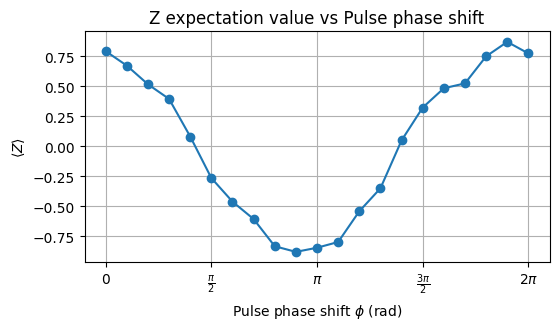

In [ ]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
phi_list = payloads[0]["phi_list"]

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_list = [z_expectation_value(r, i) for r, i in zip(data_real, data_imag)]

# グラフ描画
plt.figure(figsize=(6, 3))
plt.plot(phi_list, z_exp_list, 'o-')
plt.xlabel(r'Pulse phase shift $\phi$ (rad)')
plt.ylabel(r'$\langle Z \rangle$')
plt.title('Z expectation value vs Pulse phase shift')
plt.xticks(np.arange(0, 2*np.pi+0.1, np.pi/2), 
           [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
plt.grid(True)
plt.show()

位相はqubex.pulseのパルスクラスに対して`.shifted(phi)`で変えられますが, 別の方法としてvirtual-Zゲートによって位相フレームを回転させる (ブロッホ球上ではZ軸回転に対応) という方法もあります.  
以下の実験では, 最初に$X$軸周りのhpiパルスを照射し, その後virtual-Zゲートで$\phi$回転を行い, もう一度$X$軸周りのhpiパルスを照射し, その後$Z$期待値測定を行います.  
hpiパルスの位相自体は変えていませんが, virtual-Zゲートにより位相フレームが回転させられているので, 先ほどと同じ実験結果となるはずです.  
  
`1Q-calib-7_virtual-Z.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [109]:
payloads = experiment("1Q-calib-7_virtual-Z")

job_id = 06902103-38b6-7766-8000-548aa15f17dd
job_status = succeeded  elapsed=13.656


グラフに描画して確認してみてください.

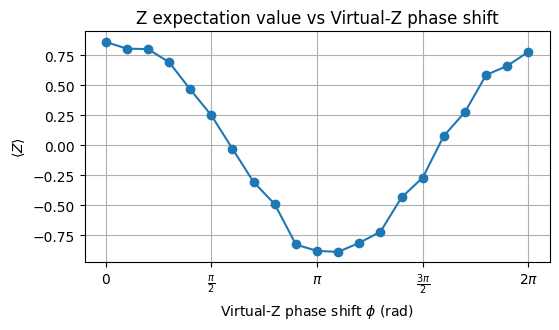

In [ ]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
phi_list = payloads[0]["phi_list"]

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_list = [z_expectation_value(r, i) for r, i in zip(data_real, data_imag)]

# グラフ描画
plt.figure(figsize=(6, 3))
plt.plot(phi_list, z_exp_list, 'o-')
plt.xlabel(r'Virtual-Z phase shift $\phi$ (rad)')
plt.ylabel(r'$\langle Z \rangle$')
plt.title('Z expectation value vs Virtual-Z phase shift')
plt.xticks(np.arange(0, 2*np.pi+0.1, np.pi/2), 
           [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])
plt.grid(True)
plt.show()

### コヒーレンス測定

以下ではqubitの性能指標であるコヒーレンスを測定していきます.  
qubitを用いた実験では, 対象qubitのコヒーレンスを知っておくことで, 実験結果の妥当性を議論することができます.  

#### T1測定

$|\rm e\rangle$状態 ($|1\rangle$) に準備されたqubitは, 時間が経つと確率的に$|\rm g\rangle$状態 ($|0\rangle$) に緩和します.  
この過程をエネルギー緩和 (縦緩和) 過程とよび, Z期待値で評価した時に$-1$から$+1$への指数減衰の時定数$T_1$をエネルギー緩和時間とよびます.  
以下の実験では, まずhpiパルスを2回照射することで$|\rm e\rangle$状態を準備し, ある時間だけ待ってからZ期待値測定を行うという流れを, 待ち時間を掃引しながら繰り返します.  

`1Q-calib-8_T1.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [111]:
payloads = experiment("1Q-calib-8_T1")

job_id = 06902105-8807-7ad3-8000-0443c4a1769f
job_status = succeeded  elapsed=20.635


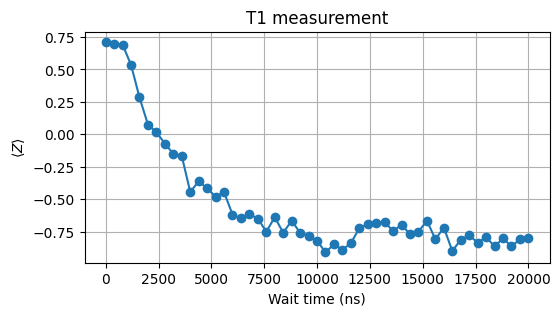

In [ ]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
time_list = payloads[0]["time_list"]

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_list = [z_expectation_value(r, i) for r, i in zip(data_real, data_imag)]

# グラフ描画
plt.figure(figsize=(6, 3))
plt.plot(time_list, z_exp_list, 'o-')
plt.xlabel('Wait time (ns)')
plt.ylabel(r'$\langle Z \rangle$')
plt.title('T1 measurement')
plt.grid(True)
plt.show()

<span style="color: red; ">**[自主作業4] 測定結果を指数関数でフィッティングすることで, T1時間を求めてください.**</span>  

[補足]
- 時間間隔を細かく指定して測定してみると, Z期待値が減衰しながら細かく振動している場合があります. これは上で触れたTLSによる影響であり, トランズモンとTLSの間で励起が周期的に交換されているためです. もちろんこのようなケースは望ましくなく, このような振動がないqubitを可能なら使用したいところであります. 
- ただし上でも述べた通り, TLSは時間的に変化するため, 別の日に測定すると振る舞いが変わっている可能性はあります.  

#### Ramsey干渉実験

$|+\rangle$状態など, ブロッホ球の赤道上に準備されたqubitは, 時間が経つと確率的にZ軸の方に緩和します.  
この過程を位相緩和 (横緩和) 過程とよび, 赤道上からZ軸への指数減衰の時定数$T_2^*$を位相緩和時間とよびます.  
位相緩和には, 状態$|0\rangle + {\rm e}^{{\rm i} \phi}|1\rangle$における$|0\rangle$と$|1\rangle$の位相差$\phi$ (ブロッホ球上での経度に対応) が時間的に揺らぐことにより生じる純位相緩和と, エネルギー緩和に伴って必然的に生じる位相緩和があり, ここでの測定ではそれら両方の効果による位相緩和時間が測定されます.  
  
以下の実験では, hpiパルスの駆動周波数をわざとqubit共鳴周波数から少しずらし(離調`detuning`を与え), この駆動周波数の回転座標系でブロッホ球上の状態の動きを考えます.   
まずhpiパルスを1回照射することで$|\rm -i\rangle$状態 ($-Y$軸の先端上の状態) を準備し, ある時間だけ待ちます.   
qubit共鳴周波数とブロッホ球のフレームの周波数 (=hpi駆動周波数) には周波数差`detuning`があるので, 待っている間, 状態はZ軸周りに周波数`detuning`で回転します.  
この時位相緩和があるなら, 回転しながらZ軸に近づくように動きます.  
その後, 位相$\pi$のhpiパルスを1回照射し, Z期待値測定を行います.  
上記の流れを, 待ち時間を掃引しながら繰り返します.  

Z期待値測定の結果は, 待ち時間を伸ばしていくにつれて, 減衰振動の振る舞いを見せるはずです. 
この振動をRamsey干渉と呼び, この減衰の時定数をフィッティングによって求めることで$T_2^*$が求められます.  
  
`1Q-calib-9_ramsey.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [113]:
payloads = experiment("1Q-calib-9_ramsey")

job_id = 06902107-ef9d-7403-8000-8a6851c3e724
job_status = succeeded  elapsed=30.543


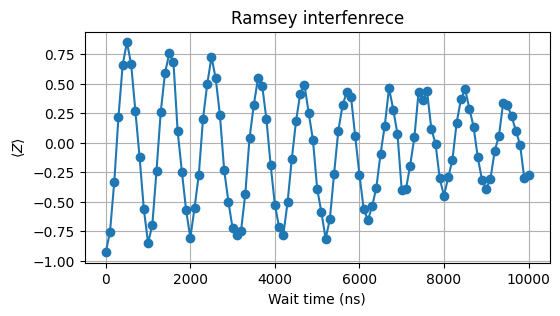

In [ ]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
time_list = payloads[0]["time_list"]

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_list = [z_expectation_value(r, i) for r, i in zip(data_real, data_imag)]

# グラフ描画
plt.figure(figsize=(6, 3))
plt.plot(time_list, z_exp_list, 'o-')
plt.xlabel('Wait time (ns)')
plt.ylabel(r'$\langle Z \rangle$')
plt.title('Ramsey interfenrece')
plt.grid(True)
plt.show()

<span style="color: red; ">**[自主作業5] 測定結果を減衰振動関数でフィッティングすることで, $T_2^*$時間を求めてください.**</span>  

#### T2 echo測定

上では, 状態$|0\rangle + {\rm e}^{{\rm i} \phi}|1\rangle$における$|0\rangle$と$|1\rangle$の位相差$\phi$ (ブロッホ球上での経度に対応) が時間的に揺らぐことにより純位相緩和が生じると説明しました.  
この揺らぎが十分遅い場合には, エコーをかけることで位相シフトをキャンセルすることができます.  
このようにして残る速い純位相緩和とエネルギー緩和に伴って生じる位相緩和によって生じる位相緩和の時定数を$T_2^{\rm echo}$とよびます.  

実際の量子計算シーケンスにおいても, 遅い位相緩和は対処可能な位相緩和であるため, うまくエコーのテクニックを用いて消去されます.  
したがってqubitの位相緩和に関する性能を本質的に表しているのは$T_2^{\rm echo}$であると言えます.  

以下の実験では, まずhpiパルスを1回照射することで$|\rm -i\rangle$状態 ($-Y$軸の先端上の状態) を準備し, ある時間の半分だけ待ちます.
次にhpiパルスを2回照射で$X$ゲートをかけることで, 位相シフトがキャンセルする方向に動くようになります. 
次に再度ある時間の半分だけ待ち, その後hpiパルスを1回照射し, Z期待値測定を行います.  
上記の流れを, 待ち時間を掃引しながら繰り返します.  

Z期待値測定の結果は, 待ち時間を伸ばしていくにつれて, $+1$から$0$に向かって指数減衰の振る舞いを見せるはずです. 
この減衰の時定数をフィッティングによって求めることで$T_2^{\rm echo}$が求められます.  
  
`1Q-calib-10_T2echo.py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [115]:
payloads = experiment("1Q-calib-10_T2echo")

job_id = 0690210a-ee13-766f-8000-b1456bedfba9
job_status = succeeded  elapsed=20.443


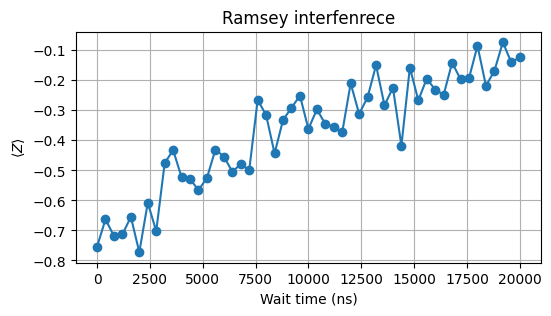

In [ ]:
# 測定で得られた全データ
data_real = payloads[0]["data_real"]
data_imag = payloads[0]["data_imag"]
time_list = payloads[0]["time_list"]

# 測定データ(data_real, data_imag)をZ期待値リストに変換
z_exp_list = [z_expectation_value(r, i) for r, i in zip(data_real, data_imag)]

# グラフ描画
plt.figure(figsize=(6, 3))
plt.plot(time_list, z_exp_list, 'o-')
plt.xlabel('Wait time (ns)')
plt.ylabel(r'$\langle Z \rangle$')
plt.title('Ramsey interfenrece')
plt.grid(True)
plt.show()

<span style="color: red; ">**[自主作業6] 測定結果を指数関数でフィッティングすることで, $T_2^{\rm echo}$時間を求めてください.**</span>  

### 読み出し分類器調整

ここまでの測定では, `shots=1024`回の積算測定を行い, IQ平面には自動的にその平均値が現れるようになっていました (だからラビ振動の際には$|\rm g\rangle$に対応する点と$|\rm e\rangle$に対応する点の間にも測定点が現れるのでした).  
1qubitを扱う上ではこのような積算測定で十分ですが, 2qubit以上を扱う場合には1shotの単発実験において, 得られる読み出しリターン信号から, その結果が$|\rm g\rangle$なのか$|\rm e\rangle$なのかを判定する必要があります.  
ここではその分類器となる関数を較正していきます.   

まずは単発測定で読み出しリターン信号がどのようになるかを観察します.  
`1Q-calib-11_single_shot_0(1).py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [45]:
payloads_0 = experiment("1Q-calib-11_single_shot_0")
payloads_1 = experiment("1Q-calib-11_single_shot_1")

job_id = 06902369-66c9-707d-8000-7c71e4a570bf
job_status = succeeded  elapsed=8.402
job_id = 0690236a-5d1f-7b20-8000-8d507630606e
job_status = succeeded  elapsed=8.224


この実験では, `measure`メソッド(`shots=1`)を用いて, qubitをそれぞれ0, 1に準備した時の単発測定における読み出し波形の取得を行っています. 　
以下ではそれらをグラフに描画してみます. 

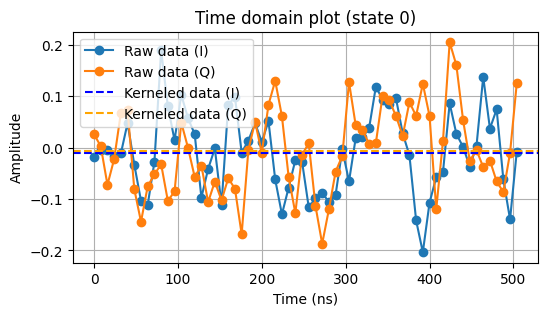

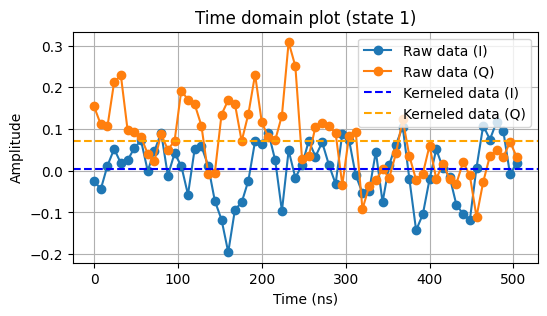

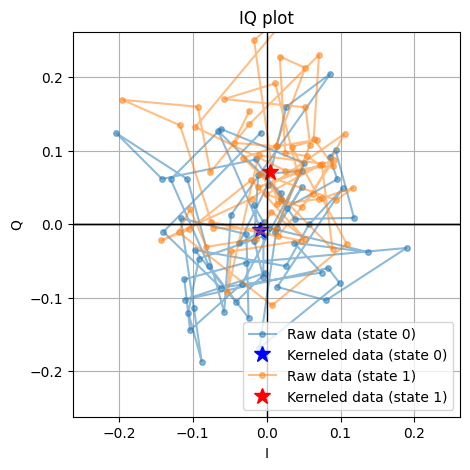

In [46]:
# 測定で得られた全データ
raw_data_real_0 = payloads_0[0]["raw_data_real"]
raw_data_imag_0 = payloads_0[0]["raw_data_imag"]
kerneled_data_real_0 = payloads_0[0]["kerneled_data_real"]
kerneled_data_imag_0 = payloads_0[0]["kerneled_data_imag"]

t_list = payloads_0[0]["time_range"]

raw_data_real_1 = payloads_1[0]["raw_data_real"]
raw_data_imag_1 = payloads_1[0]["raw_data_imag"]
kerneled_data_real_1 = payloads_1[0]["kerneled_data_real"]
kerneled_data_imag_1 = payloads_1[0]["kerneled_data_imag"]

# 時間プロットを表示
plt.figure(figsize=(6, 3))
plt.plot(t_list, raw_data_real_0, 'o-', label='Raw data (I)')
plt.plot(t_list, raw_data_imag_0, 'o-', label='Raw data (Q)')
# kerneled_dataの横線を引く
plt.axhline(kerneled_data_real_0, linestyle='--', color='b', label='Kerneled data (I)')
plt.axhline(kerneled_data_imag_0, linestyle='--', color='orange', label='Kerneled data (Q)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Time domain plot (state 0)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(t_list, raw_data_real_1, 'o-', label='Raw data (I)')
plt.plot(t_list, raw_data_imag_1, 'o-', label='Raw data (Q)')
# kerneled_dataの横線を引く
plt.axhline(kerneled_data_real_1, linestyle='--', color='b', label='Kerneled data (I)')
plt.axhline(kerneled_data_imag_1, linestyle='--', color='orange', label='Kerneled data (Q)')
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude')
plt.title('Time domain plot (state 1)')
plt.legend()
plt.grid(True)
plt.show()

# IQプロットを表示
plt.figure(figsize=(5,5))
plt.plot(raw_data_real_0, raw_data_imag_0, 'o-', label='Raw data (state 0)', markersize=4, alpha=0.5)
plt.plot(kerneled_data_real_0, kerneled_data_imag_0, '*', label='Kerneled data (state 0)', markersize=12, color='blue')
plt.plot(raw_data_real_1, raw_data_imag_1, 'o-', label='Raw data (state 1)', markersize=4, alpha=0.5)
plt.plot(kerneled_data_real_1, kerneled_data_imag_1, '*', label='Kerneled data (state 1)', markersize=12, color='red')
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axvline(0, linewidth=1, color='k')
max = np.max(np.sqrt(np.array(raw_data_real_0)**2 + np.array(raw_data_imag_0)**2)) * 1.1 # 原点を中心にする
plt.xlim(-max, max)
plt.ylim(-max, max)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ plot')
plt.legend()
plt.grid(True)
plt.show()



おそらく単発測定では, 読み出しリターン波形は非常にノイジーであり, それを時間平均したkerneled dataにおいて, わずかにqubitが0の時と1の時の系統的な違いが見えます.  
この系統的な違いが分散読み出しにより得られるqubitの情報であり, その上に乗っているノイズは主に読み出し信号が10mKから4KのHEMTによる増幅を受けるまでに重畳される熱雑音であると考えられます.  
  
では次に, この系統的な違いをはっきりと示すために, 単発測定を繰り返し行った場合のkerneled dataの分布を調べます.  
`measure`メソッドの`mode`引数を`single`に選ぶことで, `shots`で選んだ回数分の単発測定のkerneled dataが得られます.  
`1Q-calib-12_single_shot_distribution_0(1).py`内を確認し, <span style="color: red; ">**各測定パラメータを適切に設定してから**</span>, 以下を実行してください.

In [42]:
payloads_0 = experiment("1Q-calib-12_single_shot_distribution_0")
payloads_1 = experiment("1Q-calib-12_single_shot_distribution_1")

job_id = 06902355-eb0f-7d82-8000-f95f741dc252
job_status = succeeded  elapsed=8.376
job_id = 06902356-dec9-75dd-8000-8b955de0ce5a
job_status = succeeded  elapsed=8.486


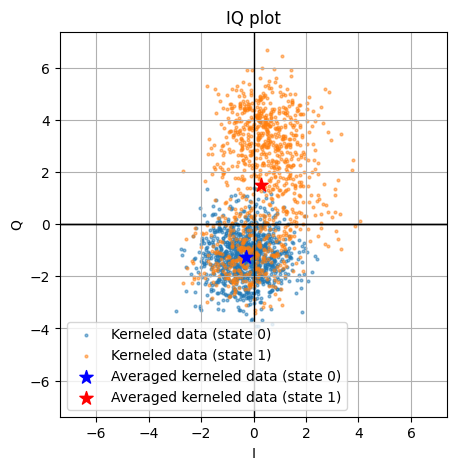

In [44]:
# 測定で得られた全データ
kerneled_data_real_0 = payloads_0[0]["kerneled_data_real"]
kerneled_data_imag_0 = payloads_0[0]["kerneled_data_imag"]
avg_kerneled_data_real_0 = np.mean(kerneled_data_real_0)
avg_kerneled_data_imag_0 = np.mean(kerneled_data_imag_0)

kerneled_data_real_1 = payloads_1[0]["kerneled_data_real"]
kerneled_data_imag_1 = payloads_1[0]["kerneled_data_imag"]
avg_kerneled_data_real_1 = np.mean(kerneled_data_real_1)
avg_kerneled_data_imag_1 = np.mean(kerneled_data_imag_1)


# IQプロットを表示
plt.figure(figsize=(5,5))
plt.scatter(kerneled_data_real_0, kerneled_data_imag_0, label='Kerneled data (state 0)', s=4, alpha=0.5)
plt.scatter(kerneled_data_real_1, kerneled_data_imag_1, label='Kerneled data (state 1)', s=4, alpha=0.5)
plt.scatter(avg_kerneled_data_real_0, avg_kerneled_data_imag_0, label='Averaged kerneled data (state 0)', s=100, color='blue', marker='*')
plt.scatter(avg_kerneled_data_real_1, avg_kerneled_data_imag_1, label='Averaged kerneled data (state 1)', s=100, color='red', marker='*')
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axhline(0, linewidth=1, color='k') # x, y軸に直線を引く
plt.axvline(0, linewidth=1, color='k')
max = np.max(np.sqrt(np.array(kerneled_data_real_1)**2 + np.array(kerneled_data_imag_1)**2)) * 1.1 # 原点を中心にする
plt.xlim(-max, max)
plt.ylim(-max, max)
plt.xlabel('I')
plt.ylabel('Q')
plt.title('IQ plot')
plt.legend()
plt.grid(True)
plt.show()


確かにqubit状態が0か1かによって分布の山は異なる場所に存在し, それぞれの平均値は離れています.  
したがって最も単純には, この2つの平均値の点の垂直2等分線をスレッショルドとして, 片側を結果'0', 反対側を結果'1'に対応させれば, 分類器が構成できます.  
  
<span style="color: red; ">**[自主作業7] 1つのkerneled data (実部, 虚部)を入力すると, 結果'0'か'1'かを返す分類器の関数を定義してください.**</span>  
  
[補足]
- qubitによっては分散シフトが非常に小さいために, 2つの山が大部分で重なってしまっている場合があります. 読み出し忠実度としては低いものになりますが, 他qubitにおける期待値測定 ($\langle ZZ \rangle$など) において単発射影測定が使われる場合は, このような読み出しエラーをうまくキャンセルする手法 (読み出しエラーミティゲーション) が存在します. したがって, 誤り訂正実験のように単発射影測定1つ1つの結果が重要であるような実験以外の用途では, 多少2つの山の重なりが大きくても, 少しでも分類ができていればOKです. 
- qubitを0に準備した場合にも, 1に対応する山の部分に出力が現れることがあります. これは, 1つ目の原因としては初期状態の熱励起によって完全に0に初期化できていない部分が現れていること, 2つ目の原因としては読み出しに伴うqubitへの反作用によって0から1に変化してしまうこと, という可能性があります. おそらくどちらも生じる確率は小さいので, ここでは気にする必要はないと思われます. 
- qubitを1に準備した場合にも, 0に対応する山の部分に出力が現れることがあります. これは, 上記の熱励起と反作用の他に, 測定中にqubitが0から1にエネルギー緩和してしまうためという原因があります. T1が短いqubitに対してはこの現象が顕著に現れます. 
- 0に対応する山, 1に対応する山のどちらからも離れたところにも, 出力が現れる場合があります. この原因の多くは量子状態が第2励起状態やそれ以上に飛んでしまっていることに起因し, IQ平面上におけるそれぞれの高準位に対応する場所に分布が生じます. 

In [71]:
def classifier(real: float, imag: float) -> int:
    """
    IQ平面上の点(real, imag)を入力とし, qubit状態'0'か'1'かを分類する関数.
    """
    # ここにコードを記述してください.
    pass

<span style="color: red; ">**[自主作業8] 作成したclassifierと`1Q-calib-12_single_shot_distribution_0(1)`の結果を用いて, 読み出し忠実度を計算してください.**</span>
- 状態$i$に準備して, 結果$j$が得られる確率が$p(j|i)$であった時, 読み出し忠実度$F$は
$$
F = \frac{p(0|0) + p(1|1)}{2}
$$  
で与えられるとします. 

### Randomized Benchmarking (TBD)

外部ファイル読み込みに関するシステム調整が必要なため, 準備は保留. 